# MyoPS 2020 Challenge


In [1]:
from fastai2.vision.all import *
from fastai2.vision.models import resnet34
from monai.losses import FocalLoss
import gc

In [2]:
path = "../data/png"

In [3]:
class AddMaskCodeMapping(Transform):
    "Add mapping of pixel value to class for a `TensorMask`"
    def __init__(self, mapping, codes=None):
        #print("init")
        self.mapping = mapping
        self.codes = codes
        if codes is not None: self.vocab,self.c = codes,len(codes)

    def encodes(self, o:PILMask):
        #print("encodes")
        mo = ToTensor()(o)
        mo = mo.to(dtype=torch.long)
        mo = self.mapping.index_select(0,mo.flatten()).reshape(*mo.shape)
        mo = PILMask.create(mo.to(dtype=torch.uint8))
        return mo
    
    def decodes(self, o:TensorMask):
        # decoding of inputs works out of the box, but get_preds are not properly decoded
        if len(o.shape) > 2:
            o = o.argmax(dim=0)
        if self.codes is not None: o._meta = {'codes': self.codes}
        return o

In [4]:
def MappedMaskBlock(mapping,codes=None):
    "A `TransformBlock` for segmentation masks, with mapping of pixel values to classes, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodeMapping(mapping=mapping,codes=codes), batch_tfms=IntToFloatTensor)

In [5]:
def getMappedMaskBlock(predefined_mapping_name):
    predefined_mappings = {
        'full': ([0,1,2,3,4,5],['bg','lv','my','rv','ed','sc']),
        'edOnly': ([0,0,0,0,1,0],['bg','ed']),
        'edScCombined': ([0,0,0,0,1,1],['bg','edSc']),
        'scOnly': ([0,0,0,0,0,1],['bg','sc']),
        'edScOnly': ([0,0,0,0,1,2],['bg','ed','sc']),
    }
    mapping,codes = predefined_mappings[predefined_mapping_name]
    return MappedMaskBlock(mapping = torch.LongTensor(mapping), codes=codes)

In [6]:
def get_train_files(path):
    items = get_image_files(path)
    items = L([x for x in items if x.name.startswith("1")])
    return items

In [7]:
def getMyopsDls(mapping_name="full", images="images"):
    mmb = getMappedMaskBlock(mapping_name)
    myopsData = DataBlock(blocks=(ImageBlock, mmb),#['bg','lv','my','rv','ed','sc'])),
        get_items=get_train_files,
        splitter=FuncSplitter(lambda o: False),
        get_y=lambda o: str(o).replace(images,"masks"),
        item_tfms=CropPad(256),
        batch_tfms=aug_transforms(max_rotate=90,pad_mode="zeros"))
    dls = myopsData.dataloaders(f'{path}/{images}',num_workers=4,batch_size=12)
    dls[1].bs = 12
    return dls

In [8]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceFG(input, targs): return multi_dice(input,targs,class_id=1)
def diceLV(input, targs): return multi_dice(input,targs,class_id=1)
def diceMY(input, targs): return multi_dice(input,targs,class_id=2)
def diceRV(input, targs): return multi_dice(input,targs,class_id=3)
def diceEd(input, targs): return multi_dice(input,targs,class_id=4)
def diceSc(input, targs): return multi_dice(input,targs,class_id=5)
dices = [diceLV,diceMY,diceRV,diceEd,diceSc]

In [9]:
def myFocal(weights=[.2,.8]):
    monaiFocal = FocalLoss(weight=torch.Tensor(weights),reduction='mean')
    return lambda input,target: monaiFocal(input, target.unsqueeze(1))

# Generic function

In [28]:
def standard_training(
    mapping="full",
    images="images",
    metrics=dices,
    weights=[1.0/6,1.0/6,1.0/6,1.0/6,1.0/6,1.0/6],
    name="standard_training",
    use_focal_loss=True,
    path='..',
    save=False,
    cleanup=True
    ):
    my_loss = None
    if(use_focal_loss):
        my_loss = myFocal(weights)
    learn = unet_learner(
        getMyopsDls(mapping, images),
        resnet34,
        path=path,
        loss_func=my_loss,
        metrics=[foreground_acc, *metrics],
        cbs=[CSVLogger(f'logs/{name}.csv',append=True)]
    )
    learn.fine_tune(40, freeze_epochs=20, base_lr=1e-3)
    if save:
        learn.save(name)
    if not cleanup:
        return learn
    del learn
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
train = standard_training(name=f"multi_ce_full", use_focal_loss=False, save=True, cleanup=False)
standard_training(name=f"multi_patho.35_full", weights=[.3/4,.3/4,.3/4,.3/4,.35,.35], save=True)
standard_training(name=f"multi_scar.4_full", weights=[.6/5,.6/5,.6/5,.6/5,.6/5,.4], save=True)
standard_training(name=f"multi_edema.4_full", weights=[.6/5,.6/5,.6/5,.6/5,.4,.6/5], save=True)
standard_training(name=f"lge_scarOnly.8_full", mapping="scOnly", images="LGE", metrics=[diceFG], weights=[0.2,0.8], save=True)
standard_training(name=f"t2_edemaOnly.8_full", mapping="edOnly", images="T2", metrics=[diceFG], weights=[0.2,0.8], save=True)

epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.785715,None,None,None,None,None,None,None,00:28
1,0.542832,None,None,None,None,None,None,None,00:28
2,0.422050,None,None,None,None,None,None,None,00:28
3,0.336563,None,None,None,None,None,None,None,00:28
4,0.281419,None,None,None,None,None,None,None,00:28
5,0.256085,None,None,None,None,None,None,None,00:28
6,0.220398,None,None,None,None,None,None,None,00:28
7,0.197050,None,None,None,None,None,None,None,00:28
8,0.176468,None,None,None,None,None,None,None,00:28
9,0.168285,None,None,None,None,None,None,None,00:28


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.104862,None,None,None,None,None,None,None,00:29
1,0.102163,None,None,None,None,None,None,None,00:29
2,0.101792,None,None,None,None,None,None,None,00:29
3,0.101185,None,None,None,None,None,None,None,00:29
4,0.100406,None,None,None,None,None,None,None,00:29
5,0.099352,None,None,None,None,None,None,None,00:29
6,0.098800,None,None,None,None,None,None,None,00:29
7,0.098344,None,None,None,None,None,None,None,00:29
8,0.097819,None,None,None,None,None,None,None,00:29
9,0.099854,None,None,None,None,None,None,None,00:29


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.041588,None,None,None,None,None,None,None,00:27
1,0.033589,None,None,None,None,None,None,None,00:27
2,0.026161,None,None,None,None,None,None,None,00:27
3,0.021637,None,None,None,None,None,None,None,00:27
4,0.018063,None,None,None,None,None,None,None,00:27
5,0.016387,None,None,None,None,None,None,None,00:27
6,0.015265,None,None,None,None,None,None,None,00:27
7,0.013602,None,None,None,None,None,None,None,00:27
8,0.012456,None,None,None,None,None,None,None,00:27
9,0.011870,None,None,None,None,None,None,None,00:27


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.006953,None,None,None,None,None,None,None,00:28
1,0.006695,None,None,None,None,None,None,None,00:28
2,0.006655,None,None,None,None,None,None,None,00:28
3,0.006627,None,None,None,None,None,None,None,00:28
4,0.006439,None,None,None,None,None,None,None,00:28
5,0.006287,None,None,None,None,None,None,None,00:28
6,0.006271,None,None,None,None,None,None,None,00:28
7,0.006449,None,None,None,None,None,None,None,00:28
8,0.006592,None,None,None,None,None,None,None,00:28
9,0.006647,None,None,None,None,None,None,None,00:28


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.062232,None,None,None,None,None,None,None,00:27
1,0.046109,None,None,None,None,None,None,None,00:27
2,0.035652,None,None,None,None,None,None,None,00:27
3,0.028042,None,None,None,None,None,None,None,00:27
4,0.023073,None,None,None,None,None,None,None,00:27
5,0.020058,None,None,None,None,None,None,None,00:27
6,0.018731,None,None,None,None,None,None,None,00:27
7,0.016731,None,None,None,None,None,None,None,00:27
8,0.015789,None,None,None,None,None,None,None,00:27
9,0.015149,None,None,None,None,None,None,None,00:27


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.008100,None,None,None,None,None,None,None,00:28
1,0.007440,None,None,None,None,None,None,None,00:28
2,0.007365,None,None,None,None,None,None,None,00:28
3,0.007094,None,None,None,None,None,None,None,00:28
4,0.007012,None,None,None,None,None,None,None,00:28
5,0.006898,None,None,None,None,None,None,None,00:28
6,0.006853,None,None,None,None,None,None,None,00:28
7,0.006870,None,None,None,None,None,None,None,00:28
8,0.007059,None,None,None,None,None,None,None,00:28
9,0.007052,None,None,None,None,None,None,None,00:28


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.076502,None,None,None,None,None,None,None,00:27
1,0.054559,None,None,None,None,None,None,None,00:27
2,0.042306,None,None,None,None,None,None,None,00:27
3,0.032788,None,None,None,None,None,None,None,00:27
4,0.026761,None,None,None,None,None,None,None,00:27
5,0.021683,None,None,None,None,None,None,None,00:27
6,0.018626,None,None,None,None,None,None,None,00:27
7,0.016580,None,None,None,None,None,None,None,00:27
8,0.014862,None,None,None,None,None,None,None,00:27
9,0.013479,None,None,None,None,None,None,None,00:27


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.008403,None,None,None,None,None,None,None,00:28
1,0.007977,None,None,None,None,None,None,None,00:28
2,0.007591,None,None,None,None,None,None,None,00:28
3,0.007428,None,None,None,None,None,None,None,00:28
4,0.007455,None,None,None,None,None,None,None,00:28
5,0.007375,None,None,None,None,None,None,None,00:28
6,0.007233,None,None,None,None,None,None,None,00:28
7,0.007275,None,None,None,None,None,None,None,00:28
8,0.007247,None,None,None,None,None,None,None,00:28
9,0.007154,None,None,None,None,None,None,None,00:28


epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.012110,None,None,None,01:12
1,0.007942,None,None,None,01:03
2,0.006240,None,None,None,01:03
3,0.005515,None,None,None,01:03
4,0.004895,None,None,None,01:03
5,0.004642,None,None,None,01:03
6,0.004292,None,None,None,01:03
7,0.004115,None,None,None,01:03
8,0.003898,None,None,None,01:03
9,0.004087,None,None,None,01:03


epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.002264,None,None,None,01:14
1,0.002083,None,None,None,01:23
2,0.002115,None,None,None,01:11
3,0.002088,None,None,None,01:06
4,0.001994,None,None,None,01:06
5,0.001945,None,None,None,01:06
6,0.001913,None,None,None,01:06
7,0.001946,None,None,None,01:06
8,0.001869,None,None,None,01:06
9,0.001839,None,None,None,01:06


epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.010532,None,None,None,01:03
1,0.006532,None,None,None,01:03
2,0.005257,None,None,None,01:03
3,0.004901,None,None,None,01:03
4,0.004552,None,None,None,01:03
5,0.004269,None,None,None,01:03
6,0.004173,None,None,None,01:03


In [23]:
pred = train.predict(f'{path}/images/201-orig-0.png')

In [24]:
pred[0].shape, pred[1].shape, pred[2].shape

(torch.Size([256, 256]), torch.Size([256, 256]), torch.Size([6, 256, 256]))

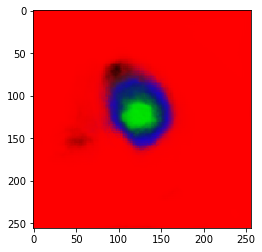

In [25]:
plt.imshow(pred[2][0:3].permute(1,2,0))

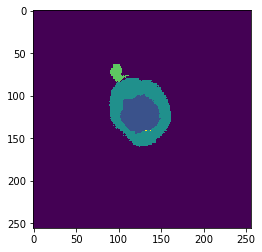

In [26]:
plt.imshow(pred[1])

In [ ]:
del learn
gc.collect()
torch.cuda.empty_cache()